In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from ot import emd2  # Wasserstein distance computation
from tqdm import tqdm

%matplotlib widget

# check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
Gaussian Mixture Model

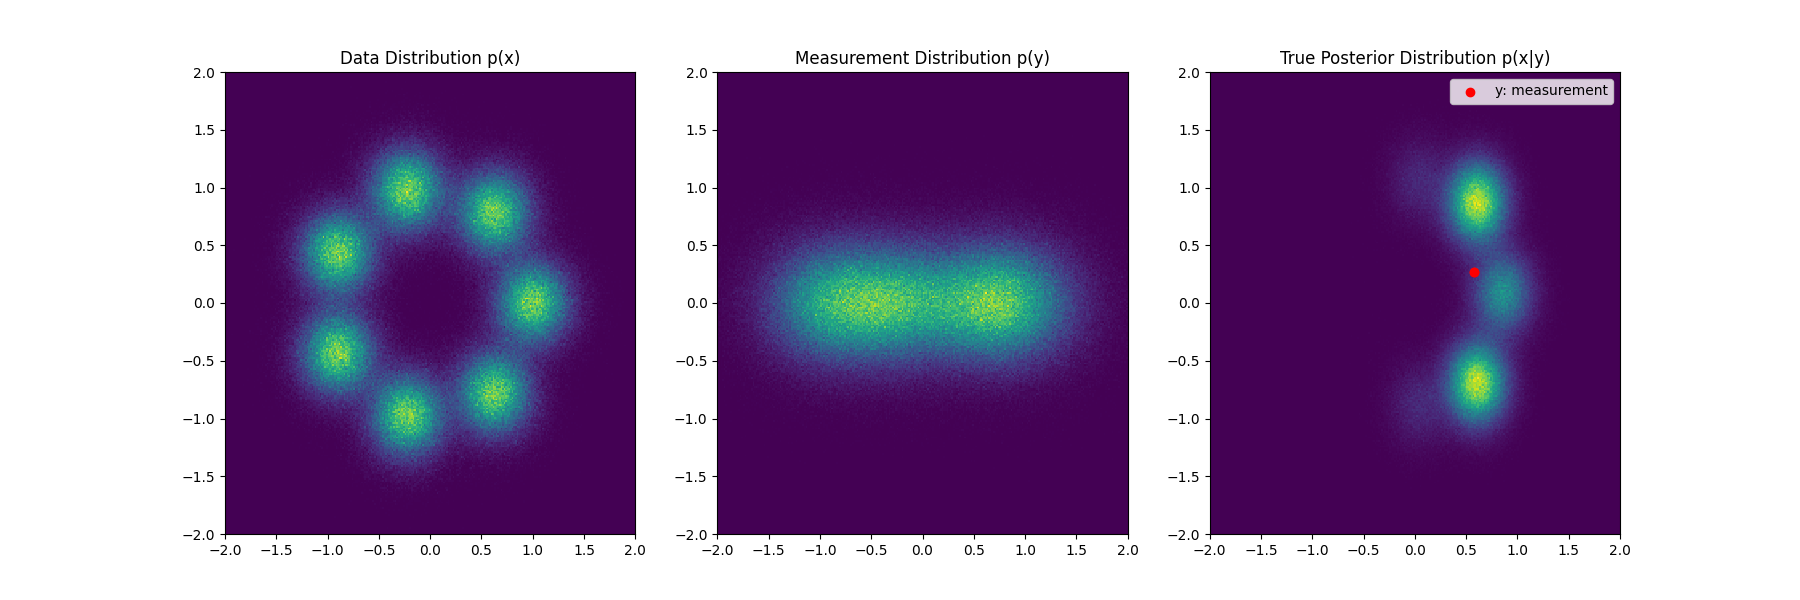

In [488]:
from scipy.stats import multivariate_normal
from sklearn.datasets import make_moons


class DataDistribution:
    def __init__(self, config):
        self.mu = []
        self.sig = []
        self.L_sig = []
        self.generator = np.random.RandomState(0)
        # get mus from config
        for i in range(len(config['gaussians'])):
            self.mu.append(np.array(config['gaussians'][i]['mu']))
            self.sig.append(np.array(config['gaussians'][i]['cov']))
            self.L_sig.append(np.linalg.cholesky(self.sig[i]))
        self.mu = np.array(self.mu)
        self.sig = np.array(self.sig)
        self.L_sig = np.array(self.L_sig)

    def __call__(self, n_samples=1):
        # sample which gaussian to sample from use random state
        idx = np.random.choice(len(self.mu), n_samples)
        # sample from the chosen gaussian
        
        return self.mu[idx][...,0] + np.einsum("nij, nj->ni", self.L_sig[idx], np.random.randn(n_samples, 2)) #self.L_sig[idx]@np.random.randn(2, n_samples).T)
    
    def sample(self, n_samples=1):
        return self(n_samples)

config = {
'gaussians': [
    {'mu': [[3],[-6]], 'cov': [[1,0.25],[0.25,1]]},
    {'mu': [[-2],[3]], 'cov': [[2,-1.5],[-1.5,2]]},
    {'mu': [[3],[6]], 'cov': [[0.2,-0.1],[-0.1,2]]}
]}

data_dist = DataDistribution(config)

# config for 8 gaussians in a circle
r  = 1
sigma = 5e-2
n_gaussians = 7
config_circle = {
'gaussians': [
    {'mu': [[r*np.cos(2*np.pi*i/n_gaussians)],[r*np.sin(2*np.pi*i/n_gaussians)]], 'cov': [[sigma,0],[0,sigma]]} for i in range(n_gaussians)
]}

gaussian_circle = DataDistribution(config_circle)

# define forward process and degrade data with forward process and noise
class BasicForwardModel:
    def __init__(self, data_distribution, config):
        self.data_dist = data_distribution
        # identity matrix
        self.A = np.array([[1,0],[0,1]])
        # noise level
        self.mu = np.array(config['mu'])
        self.sig = np.diag(np.array(config['cov']))
        self.L_sig = np.linalg.cholesky(self.sig)
    
    def __call__(self, n_samples=1):
        # forward process
        x = self.data_dist(n_samples)
        # forward operator
        y = x@self.A.T
        # add noise
        
        y += (self.L_sig@np.random.randn(2, n_samples)).T + self.mu[None]
        return y
    
    def get_p_y(self, y):
        p_y = []
        for j in range(self.data_dist.mu.shape[0]):
            mu = self.A@self.data_dist.mu[j] + self.mu[:,None]
            sig = self.A@self.data_dist.sig[j]@self.A.T + self.sig
            p_y.append(multivariate_normal.pdf(y, mean=mu[:,0],cov=sig))
        return p_y
    
    def unnormalized_posterior(self, y):
        self.post_mu = []
        self.post_sig = []
        self.post_cholesky = []
        for i in range(self.data_dist.mu.shape[0]):
            mu_data = self.data_dist.mu[i][None]
            sig_data = self.data_dist.sig[i][None]
            mu_post = mu_data + (sig_data @ np.linalg.inv(sig_data + self.sig)) @ (y[...,None] - self.A[None]@mu_data)
            self.post_mu.append(mu_post[0])
            sig_post = sig_data - self.A[None]@sig_data @ np.linalg.inv(sig_data + self.sig) @ self.A[None]@sig_data
            self.post_sig.append(sig_post[0])
            self.post_cholesky.append(np.linalg.cholesky(sig_post[0]))
        self.post_mu = np.array(self.post_mu)
        self.post_sig = np.array(self.post_sig)
        self.post_cholesky = np.array(self.post_cholesky)
    
    def sample_posterior(self, y, n_samples=1):
        self.unnormalized_posterior(y)
        p_y = self.get_p_y(y)
        # sample idx of gaussian with probability p_y
        idx = np.random.choice(self.post_mu.shape[0], n_samples, p=p_y/np.sum(p_y))
        return self.post_mu[idx][...,0] + np.einsum("nij, nj->ni", self.post_cholesky[idx], np.random.randn(n_samples, 2))

    def set_A(self, A):
        self.A = A


class MoonDataset:
    def __init__(noise=0.05):
        self.noise = noise

    def __call__(self, n_samples=1):
        x = make_moons(n_samples, noise=self.noise)[0]
        x = torch.tensor(x).type(torch.float32)
        return x
    
    def sample(self, n_samples=1):
        return self(n_samples)
    
measurement_model = BasicForwardModel(gaussian_circle, {'mu': [0,0], 'cov': [0.1,0.1]})
# projection on x-axis
measurement_model.set_A(np.array([[1,0],[0,0]]))
# plot posterior samples
# 1. sample measurement
n_samples = 1000000
y = measurement_model(1)
y_samples = measurement_model(n_samples)
x_samples = gaussian_circle(n_samples)
post_samples = measurement_model.sample_posterior(y, n_samples)
# plot measurement_model.post_mu
# aspect ratio 1:1
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# plot
axs[0].set_title('Data Distribution p(x)')
axs[0].hist2d(x_samples[:,0],x_samples[:,1],bins=256, range=[[-2, 2], [-2, 2]])
axs[1].set_title('Measurement Distribution p(y)')
axs[1].hist2d(y_samples[:,0],y_samples[:,1],bins=256, range=[[-2, 2], [-2, 2]])
axs[2].set_title('True Posterior Distribution p(x|y)')
axs[2].hist2d(post_samples[:,0],post_samples[:,1],bins=256, range=[[-2, 2], [-2, 2]])
axs[2].scatter(y[:,0],y[:,1],c='r',label='y: measurement')
axs[2].legend()
# label with 'true posterior'


plt.scatter(y[0,0],y[0,1],c='r')
plt.show()


# Define Network

In [489]:
# define score matching network
from torch import nn
from torch.nn import functional as F
import math

class BasicScoreNet(nn.Module):
    def __init__(self, hidden_size=128):
        super(BasicScoreNet, self).__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, 2)
       
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        # x += self.temporal_embedding(t)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = self.fc6(x)
        return x

    def sample(self, t, x):
        t = torch.ones(x.shape[0],1, device=x.device).type(torch.float32)*t
        x = torch.cat([x, t],1)
        return self.forward(x)


    def temporal_embedding(self, timesteps, max_period=1000):
        """
        Generate temporal embeddings for diffusion models.
        
        Args:
            timesteps (torch.Tensor): Tensor of shape (batch_size,) containing the time steps.
            embedding_dim (int): Dimension of the embedding vector.
            max_period (float): Maximum period for the sinusoidal functions.
            device (str): The device to place the tensor on ('cpu' or 'cuda').

        Returns:
            torch.Tensor: Temporal embedding tensor of shape (batch_size, embedding_dim).
        """
        # Ensure timesteps are a tensor of shape (batch_size,)
        timesteps = timesteps.to(device).float().unsqueeze(1)
        
        # Compute the sinusoidal frequencies
        half_dim = self.hidden_size // 2
        exponent = torch.arange(half_dim, device=device).float() / half_dim
        frequencies = max_period ** (-exponent)
        
        # Compute the sinusoidal embedding
        angles = timesteps * frequencies  # Shape: (batch_size, half_dim)
        embedding = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)  # Shape: (batch_size, embedding_dim)
        
        return embedding
    



## DDPM Training

In [495]:
# DDPM / VP score matching
beta_min = 1e-4
beta_max = 0.02
num_steps = 1000
betas = torch.linspace(beta_min,beta_max,num_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
training_iterations = 1000

batch_size = 2048
denoiser = BasicScoreNet(hidden_size=256).to(device)
optimizer = torch.optim.AdamW(denoiser.parameters(),1e-2,(.9,.999),weight_decay=0)
data = gaussian_circle
loss_avg = []
for i in tqdm(range(training_iterations)):
    # sample timestep
    t = torch.randint(0,num_steps,(batch_size,)).to(device)
    alpha_cumprod_t = alpha_cumprod[t]
    # sample datapoint
    x = torch.tensor(data.sample(batch_size)).type(torch.float32).to(device)
    # sample noise
    eps = torch.randn(batch_size,2).to(device)
    # noise sample
    x_t = alpha_cumprod_t[:,None] * x + eps * (1-alpha_cumprod_t[:,None])
    # compute scores
    eps_pred = denoiser(torch.cat([x_t, t[:,None]/1000], 1))
    # eps_pred = denoiser(x_t, t)
    # compute loss
    loss = torch.mean((eps_pred - eps)**2)
    loss_avg.append(loss.item())
    if len(loss_avg) > 100:
        loss_avg.pop(0)
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # if i % 100 == 0: print(sum(loss_avg)/len(loss_avg))

print('done')
print(f"loss: {loss.item()}")
n_samples = 10000
x_samples = gaussian_circle(100000)
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 1}
x_t = torch.randn(n_samples,2).to(device)
# 1. DDPM
traj_xprior = guided_ddim_sampler(denoiser, y,ddim_config , x_t, likelihood_weight=0.00)
print("DDIM done")
computed_wd = compute_WD(traj_xprior[-1], x_samples)
print(f"Computed WD: {computed_wd}")

100%|██████████| 10000/10000 [00:52<00:00, 190.79it/s]


done
loss: 0.2119796872138977


## Flow Matching Training

In [366]:

# Flow Matching
training_iterations = 10000

batch_size = 2048
denoiser_flow = BasicScoreNet(hidden_size=128).to(device)
optimizer = torch.optim.AdamW(denoiser_flow.parameters(),1e-3,(.9,.999),weight_decay=1e-2)
sig_min = 1e-4
data = gaussian_circle
for i in tqdm(range(training_iterations)):
    # sample timestep
    t = torch.rand((batch_size,)).to(device)[:, None]
    # sample datapoint
    x1 = torch.tensor(data.sample(batch_size)).type(torch.float32).to(device)
    # sample noise
    x0 = torch.randn(batch_size, 2).to(device)
    # interpolate between samples
    x_t = (sig_min + (1 - sig_min) * t) * x1 + (1 - t) * x0
    # compute drift v
    v = denoiser_flow(torch.cat([x_t, t], 1))
    # compute loss
    loss = torch.mean((v - (x1 - x0 * (1 - sig_min))) ** 2)
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0:
        tqdm.write(f"Loss: {loss.item()}")

print('done')
print(f"loss: {loss.item()}")


  1%|          | 76/10000 [00:00<00:25, 392.68it/s]

Loss: 1.5459179878234863


  2%|▏         | 167/10000 [00:00<00:22, 430.95it/s]

Loss: 1.1215068101882935


  3%|▎         | 261/10000 [00:00<00:21, 451.49it/s]

Loss: 1.112294316291809


  4%|▎         | 352/10000 [00:00<00:21, 446.82it/s]

Loss: 1.1193715333938599


  4%|▍         | 442/10000 [00:01<00:22, 428.08it/s]

Loss: 1.1025701761245728


  6%|▌         | 581/10000 [00:01<00:20, 449.02it/s]

Loss: 1.1338920593261719


  7%|▋         | 673/10000 [00:01<00:20, 451.78it/s]

Loss: 1.1121875047683716


  8%|▊         | 762/10000 [00:01<00:21, 424.76it/s]

Loss: 1.1296955347061157


  8%|▊         | 847/10000 [00:01<00:22, 409.11it/s]

Loss: 1.1050128936767578


 10%|▉         | 982/10000 [00:02<00:21, 428.43it/s]

Loss: 1.1440303325653076


 11%|█         | 1071/10000 [00:02<00:20, 435.04it/s]

Loss: 1.1092368364334106


 12%|█▏        | 1167/10000 [00:02<00:19, 458.72it/s]

Loss: 1.1313674449920654


 13%|█▎        | 1266/10000 [00:02<00:18, 475.40it/s]

Loss: 1.1149946451187134


 14%|█▎        | 1359/10000 [00:03<00:19, 435.00it/s]

Loss: 1.1003917455673218


 14%|█▍        | 1448/10000 [00:03<00:19, 431.41it/s]

Loss: 1.090453863143921


 16%|█▌        | 1584/10000 [00:03<00:19, 436.26it/s]

Loss: 1.0998473167419434


 17%|█▋        | 1675/10000 [00:03<00:19, 437.52it/s]

Loss: 1.116518497467041


 18%|█▊        | 1764/10000 [00:04<00:18, 436.45it/s]

Loss: 1.114565372467041


 19%|█▊        | 1857/10000 [00:04<00:18, 450.78it/s]

Loss: 1.062579870223999


 19%|█▉        | 1949/10000 [00:04<00:18, 428.39it/s]

Loss: 1.0970537662506104


 21%|██        | 2092/10000 [00:04<00:17, 461.43it/s]

Loss: 1.09805166721344


 22%|██▏       | 2185/10000 [00:04<00:17, 456.40it/s]

Loss: 1.0633316040039062


 23%|██▎       | 2278/10000 [00:05<00:17, 453.12it/s]

Loss: 1.0707917213439941


 24%|██▍       | 2375/10000 [00:05<00:16, 461.10it/s]

Loss: 1.1102513074874878


 25%|██▍       | 2470/10000 [00:05<00:16, 460.44it/s]

Loss: 1.0824556350708008


 26%|██▌       | 2563/10000 [00:05<00:17, 433.83it/s]

Loss: 1.0337493419647217


 26%|██▋       | 2650/10000 [00:06<00:17, 415.95it/s]

Loss: 1.1195811033248901


 28%|██▊       | 2789/10000 [00:06<00:16, 440.30it/s]

Loss: 1.0978378057479858


 29%|██▉       | 2881/10000 [00:06<00:16, 437.10it/s]

Loss: 1.1268258094787598


 30%|██▉       | 2970/10000 [00:06<00:15, 439.42it/s]

Loss: 1.0798972845077515


 31%|███       | 3059/10000 [00:06<00:16, 427.68it/s]

Loss: 1.0670064687728882


 31%|███▏      | 3145/10000 [00:07<00:16, 420.70it/s]

Loss: 1.1212902069091797


 33%|███▎      | 3273/10000 [00:07<00:16, 401.53it/s]

Loss: 1.1530064344406128


 34%|███▎      | 3363/10000 [00:07<00:15, 424.91it/s]

Loss: 1.0835976600646973


 34%|███▍      | 3449/10000 [00:07<00:15, 421.66it/s]

Loss: 1.1013338565826416


 36%|███▌      | 3589/10000 [00:08<00:14, 454.08it/s]

Loss: 1.0458178520202637


 37%|███▋      | 3681/10000 [00:08<00:14, 448.93it/s]

Loss: 1.0952973365783691


 38%|███▊      | 3770/10000 [00:08<00:14, 431.13it/s]

Loss: 1.114220142364502


 39%|███▊      | 3863/10000 [00:08<00:13, 447.14it/s]

Loss: 1.0972529649734497


 40%|███▉      | 3955/10000 [00:09<00:13, 447.78it/s]

Loss: 1.103083848953247


 40%|████      | 4047/10000 [00:09<00:13, 448.54it/s]

Loss: 1.0759752988815308


 41%|████▏     | 4137/10000 [00:09<00:13, 420.01it/s]

Loss: 1.1462057828903198


 43%|████▎     | 4278/10000 [00:09<00:12, 440.43it/s]

Loss: 1.1179256439208984


 44%|████▎     | 4369/10000 [00:10<00:12, 444.91it/s]

Loss: 1.0887410640716553


 45%|████▍     | 4466/10000 [00:10<00:11, 461.79it/s]

Loss: 1.1389943361282349


 46%|████▌     | 4560/10000 [00:10<00:11, 461.63it/s]

Loss: 1.0940511226654053


 47%|████▋     | 4653/10000 [00:10<00:11, 455.10it/s]

Loss: 1.090482234954834


 47%|████▋     | 4748/10000 [00:10<00:11, 458.66it/s]

Loss: 1.0697031021118164


 49%|████▉     | 4883/10000 [00:11<00:11, 428.79it/s]

Loss: 1.122363567352295


 50%|████▉     | 4972/10000 [00:11<00:11, 434.68it/s]

Loss: 1.104731798171997


 51%|█████     | 5068/10000 [00:11<00:10, 455.87it/s]

Loss: 1.1179617643356323


 52%|█████▏    | 5160/10000 [00:11<00:11, 428.29it/s]

Loss: 1.1240628957748413


 53%|█████▎    | 5252/10000 [00:11<00:10, 440.79it/s]

Loss: 1.1132973432540894


 53%|█████▎    | 5342/10000 [00:12<00:10, 430.30it/s]

Loss: 1.0837944746017456


 55%|█████▍    | 5477/10000 [00:12<00:10, 427.61it/s]

Loss: 1.0883159637451172


 56%|█████▌    | 5566/10000 [00:12<00:10, 433.24it/s]

Loss: 1.081816554069519


 57%|█████▋    | 5659/10000 [00:12<00:09, 447.13it/s]

Loss: 1.0643445253372192


 58%|█████▊    | 5753/10000 [00:13<00:09, 455.20it/s]

Loss: 1.0716991424560547


 58%|█████▊    | 5845/10000 [00:13<00:09, 440.22it/s]

Loss: 1.061788558959961


 60%|█████▉    | 5985/10000 [00:13<00:08, 455.21it/s]

Loss: 1.0706487894058228


 61%|██████    | 6078/10000 [00:13<00:08, 456.52it/s]

Loss: 1.1320195198059082


 62%|██████▏   | 6174/10000 [00:14<00:08, 456.36it/s]

Loss: 1.0791127681732178


 63%|██████▎   | 6267/10000 [00:14<00:08, 456.66it/s]

Loss: 1.0814735889434814


 64%|██████▎   | 6359/10000 [00:14<00:08, 433.37it/s]

Loss: 1.121853232383728


 65%|██████▍   | 6451/10000 [00:14<00:08, 439.80it/s]

Loss: 1.0976123809814453


 66%|██████▌   | 6585/10000 [00:15<00:07, 435.39it/s]

Loss: 1.0943790674209595


 67%|██████▋   | 6679/10000 [00:15<00:07, 452.81it/s]

Loss: 1.0948647260665894


 68%|██████▊   | 6772/10000 [00:15<00:07, 455.70it/s]

Loss: 1.1541407108306885


 69%|██████▊   | 6864/10000 [00:15<00:07, 427.80it/s]

Loss: 1.0645393133163452


 70%|██████▉   | 6958/10000 [00:15<00:06, 440.37it/s]

Loss: 1.087816596031189


 71%|███████   | 7052/10000 [00:16<00:06, 450.41it/s]

Loss: 1.0671194791793823


 71%|███████▏  | 7148/10000 [00:16<00:06, 458.20it/s]

Loss: 1.0488253831863403


 72%|███████▏  | 7242/10000 [00:16<00:06, 428.94it/s]

Loss: 1.1045581102371216


 74%|███████▎  | 7373/10000 [00:16<00:06, 424.81it/s]

Loss: 1.0666821002960205


 75%|███████▍  | 7463/10000 [00:17<00:05, 435.37it/s]

Loss: 1.1008515357971191


 76%|███████▌  | 7552/10000 [00:17<00:05, 426.62it/s]

Loss: 1.1057775020599365


 76%|███████▋  | 7642/10000 [00:17<00:05, 436.08it/s]

Loss: 1.083862066268921


 78%|███████▊  | 7776/10000 [00:17<00:05, 435.55it/s]

Loss: 1.095555067062378


 79%|███████▊  | 7863/10000 [00:17<00:05, 421.91it/s]

Loss: 1.1149154901504517


 80%|███████▉  | 7953/10000 [00:18<00:04, 434.42it/s]

Loss: 1.0935008525848389


 81%|████████  | 8098/10000 [00:18<00:04, 465.28it/s]

Loss: 1.12593412399292


 82%|████████▏ | 8192/10000 [00:18<00:03, 461.18it/s]

Loss: 1.0814796686172485


 83%|████████▎ | 8286/10000 [00:18<00:03, 445.60it/s]

Loss: 1.1291910409927368


 84%|████████▍ | 8383/10000 [00:19<00:03, 461.85it/s]

Loss: 1.0997064113616943


 85%|████████▍ | 8477/10000 [00:19<00:03, 463.08it/s]

Loss: 1.1060434579849243


 86%|████████▌ | 8580/10000 [00:19<00:02, 475.76it/s]

Loss: 1.1527624130249023


 87%|████████▋ | 8681/10000 [00:19<00:02, 480.88it/s]

Loss: 1.047793984413147


 88%|████████▊ | 8781/10000 [00:19<00:02, 482.53it/s]

Loss: 1.0592327117919922


 89%|████████▉ | 8879/10000 [00:20<00:02, 481.94it/s]

Loss: 1.0735645294189453


 90%|████████▉ | 8977/10000 [00:20<00:02, 475.30it/s]

Loss: 1.0402183532714844


 91%|█████████ | 9073/10000 [00:20<00:01, 473.20it/s]

Loss: 1.13441002368927


 92%|█████████▏| 9171/10000 [00:20<00:01, 480.27it/s]

Loss: 1.0915342569351196


 93%|█████████▎| 9268/10000 [00:20<00:01, 463.62it/s]

Loss: 1.0989630222320557


 94%|█████████▎| 9361/10000 [00:21<00:01, 441.66it/s]

Loss: 1.1081724166870117


 95%|█████████▍| 9451/10000 [00:21<00:01, 415.55it/s]

Loss: 1.1091971397399902


 96%|█████████▌| 9590/10000 [00:21<00:00, 443.94it/s]

Loss: 1.1065952777862549


 97%|█████████▋| 9684/10000 [00:21<00:00, 451.14it/s]

Loss: 1.1137632131576538


 98%|█████████▊| 9777/10000 [00:22<00:00, 453.49it/s]

Loss: 1.1141154766082764


 99%|█████████▊| 9874/10000 [00:22<00:00, 459.45it/s]

Loss: 1.107265591621399


100%|█████████▉| 9968/10000 [00:22<00:00, 456.13it/s]

Loss: 1.1183851957321167


100%|██████████| 10000/10000 [00:22<00:00, 442.58it/s]

done
loss: 1.100145697593689


## DDIM Test Time Guidance


In [491]:
y_measurements = torch.Tensor(measurement_model(100)).to(device)
y = y_measurements[:1]


start point tensor([[ 1.8588, -0.5588]])


Text(0.5, 1.0, 'Density and Trajectory DDIM eta=0.0')

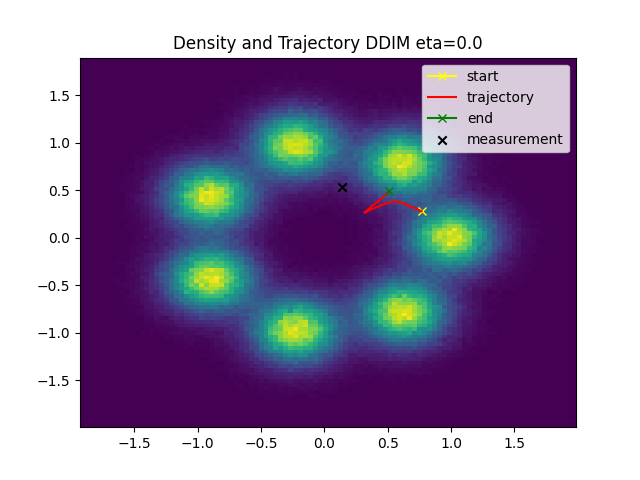

In [336]:

x_t = torch.randn(1,2).to(device)
print("start point", x_t)


def guided_ddim_sampler(model, y, ddim_config, x_t, likelihood_weight = 0.005, save_traj=False):
    if x_t is None:
        x_t = torch.randn(1,2).to(device)
    n_ddim_steps = ddim_config['n_ddim_steps']
    n_steps = ddim_config['n_steps']
    eta = ddim_config['eta']
    skip = int(n_steps/n_ddim_steps)
    timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
    betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
    alpha = 1 - betas
    alpha_cumprod = torch.cumprod(alpha, 0)
    if save_traj:
        traj = [x_t.detach().cpu().numpy()]
    for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
        with torch.no_grad():
            a_t = alpha_cumprod[t]
            a_t_next = alpha_cumprod[t_next]
            eps_pred = model(torch.cat([x_t, torch.ones(x_t.shape[0],1).to(device)*t/1000], 1))
            # ddim step
            x0_t = (x_t - eps_pred * (1-a_t)**0.5) / a_t**0.5
            c1 = eta * ((1-a_t/a_t_next)* (1-a_t_next)/(1-a_t))**0.5
            c2 = ((1-a_t_next) - c1 **2)**0.5
            x_t = a_t_next**0.5 *x0_t + c1 * torch.randn_like(x_t) + c2 * eps_pred
            with torch.enable_grad():
                x_t.requires_grad_()
                y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_t.T).T
                loss = torch.sum((y_generated - y)**2)
                loss.backward()
                gradients = x_t.grad
            # data term
            x_t = x_t - likelihood_weight * gradients
            if save_traj:
                traj.append(x_t.detach().cpu().numpy())
    return traj if save_traj else [x_t.detach().cpu().numpy()]

ddim_config = {'n_ddim_steps': 100, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.0}
x_t = torch.randn(1,2).to(device)
traj = guided_ddim_sampler(denoiser, y,ddim_config , x_t, save_traj=True)
# draw trajectory on density plot
plt.figure()
plt.title('Density and Trajectory')
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)
plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# plot meaasurement y
plt.scatter(y[0,0].detach().cpu().numpy(),y[0,1].detach().cpu().numpy(), color='black', marker='x')
# add legend
plt.legend(['start','trajectory','end', 'measurement'])
# name
plt.title(f'Density and Trajectory DDIM eta={ddim_config["eta"]}')



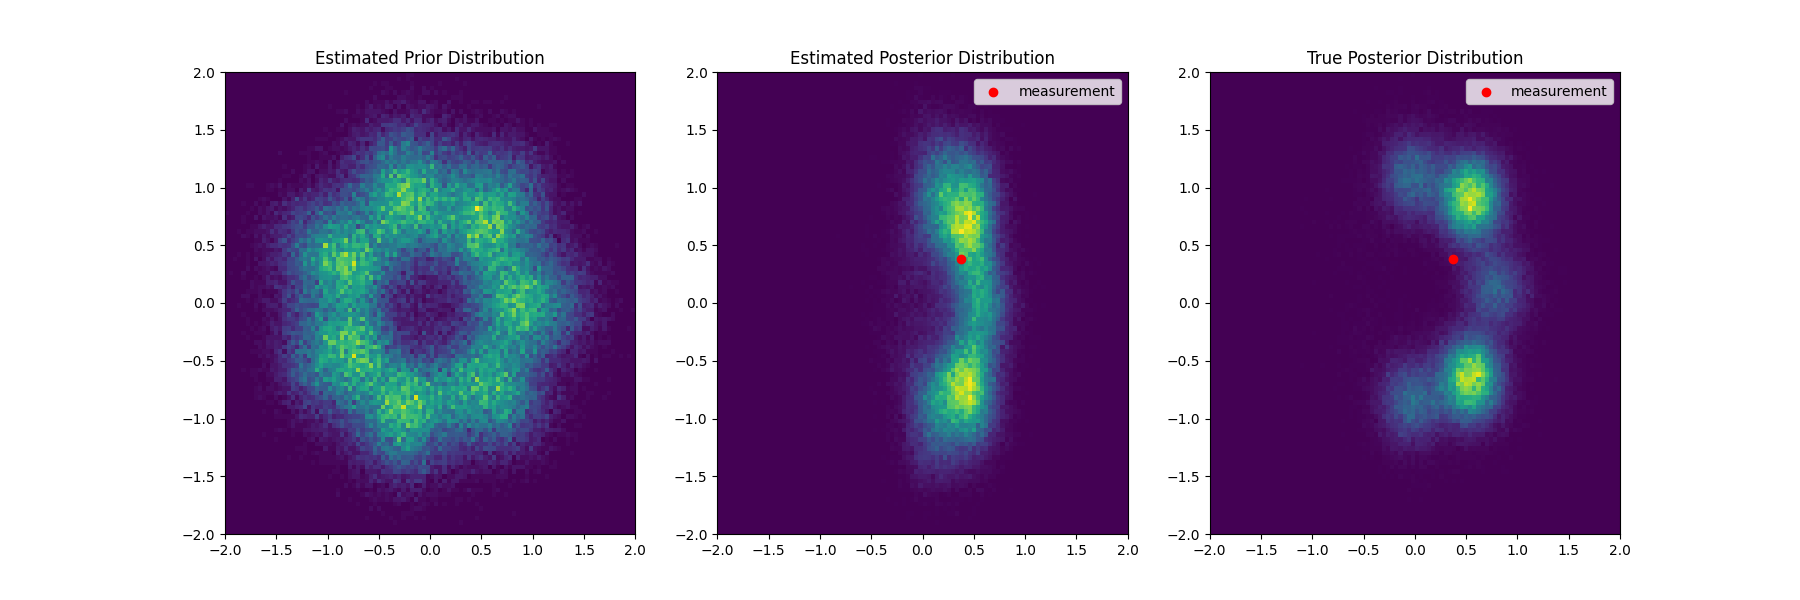

In [492]:
# compare posterior
n_samples = 10000
bins = 100
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 1}
x_t = torch.randn(n_samples,2).to(device)
traj = guided_ddim_sampler(denoiser, y,ddim_config , x_t, likelihood_weight=0.005)
traj_xprior = guided_ddim_sampler(denoiser, y,ddim_config , x_t, likelihood_weight=0.00)

# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#plot estimated prior
axs[0].set_title('Estimated Prior Distribution')
hist = axs[0].hist2d(traj_xprior[-1][:,0], traj_xprior[-1][:,1], bins=bins, range=[[-2, 2], [-2, 2]])

# Plot estimated posterior distribution
axs[1].set_title('Estimated Posterior Distribution')
hist = axs[1].hist2d(traj[-1][:,0], traj[-1][:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])

# Plot true posterior distribution
axs[2].set_title('True Posterior Distribution')
hist = axs[2].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[2].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[2].legend(['measurement'])

plt.show()
# compute Wasserstein distance of posterior samples and true posterior
estimated_samples = traj[-1]



In [382]:
def compute_WD(ground_truth_samples, estimated_samples):
    bins = 75
    H1, x_edges, y_edges = np.histogram2d(ground_truth_samples[:, 0], ground_truth_samples[:, 1], bins=bins, range=[[-1.5, 1.5], [-1.5, 1.5]])
    H2, _, _ = np.histogram2d(estimated_samples[:, 0], estimated_samples[:, 1], bins=bins, range=[[-1.5, 1.5], [-1.5, 1.5]])
    # normalize
    H1 = H1 / np.sum(H1)
    H2 = H2 / np.sum(H2)
    # Create cost matrix for the binned data
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Bin centers for x
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])  # Bin centers for y

    # Create a grid of centers
    X, Y = np.meshgrid(x_centers, y_centers)

    # Flatten the grid to match flattened histograms
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)

    # Compute pairwise squared distances between all grid points
    cost_matrix = np.linalg.norm(grid_points[:, None, :] - grid_points[None, :, :], axis=2)


    wasserstein_distance_histogram = emd2(H1.flatten(), H2.flatten(), cost_matrix)
    return wasserstein_distance_histogram

In [10]:
wd_distances = []
for y in y_measurements:
    # compare posterior
    n_samples = 10000
    bins = 75
    ddim_config = {'n_ddim_steps': 100, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.0}
    
    x_t = torch.randn(n_samples,2).to(device)
    traj = guided_ddim_sampler(denoiser, y,ddim_config , x_t)
    # sample from true posterior
    ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
    # histogram
    wasserstein_distance_histogram = compute_WD(ground_truth_samples, traj[-1])
    print("Wasserstein Distance on Binned Data:", wasserstein_distance_histogram)
    wd_distances.append(wasserstein_distance_histogram)
wd_distances = np.array(wd_distances)
print("Mean Wasserstein Distance:", np.mean(wd_distances))


Wasserstein Distance on Binned Data: 0.20067095652348968
Wasserstein Distance on Binned Data: 0.287948017632707
Wasserstein Distance on Binned Data: 0.2599412090353575
Wasserstein Distance on Binned Data: 0.23521505299037995
Wasserstein Distance on Binned Data: 0.24373592627696963
Wasserstein Distance on Binned Data: 0.29304640020690537
Wasserstein Distance on Binned Data: 0.24999014886875465
Wasserstein Distance on Binned Data: 0.22359072076523734
Wasserstein Distance on Binned Data: 0.28492284109016874
Wasserstein Distance on Binned Data: 0.17994954428180293
Wasserstein Distance on Binned Data: 0.22015817289567663
Wasserstein Distance on Binned Data: 0.24185837460798876
Wasserstein Distance on Binned Data: 0.30108700030509605
Wasserstein Distance on Binned Data: 0.2509151618569723
Wasserstein Distance on Binned Data: 0.20386929410389
Wasserstein Distance on Binned Data: 0.3182722662300435
Wasserstein Distance on Binned Data: 0.21218136720190428
Wasserstein Distance on Binned Data: 0.

In [367]:
# flow matching posterior
def guided_flow_sampler(model, y, config, x_t, save_traj=False):
    if x_t is None:
        x_t = torch.randn(1,2).to(device)
    n_steps = config['n_steps']
    likelihood_weight = config['likelihood_weight']
    timesteps = np.linspace(0, 1, n_steps)
    if save_traj:
        traj = [x_t.detach().cpu().numpy()]
    with torch.no_grad():
        for i, (t_prev, t_curr) in enumerate(zip(timesteps[:-1], timesteps[1:])):
            v_pred = model(torch.cat([x_t, torch.ones(x_t.shape[0],1).to(device)*t_curr], 1))
            dt = t_curr - t_prev
            with torch.enable_grad():
                x_t.requires_grad_()
                y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_t.T).T
                loss = torch.sum((y_generated - y)**2)
                loss.backward()
                gradients = x_t.grad
            x_t = x_t + dt * v_pred - gradients * likelihood_weight
            if save_traj:
                traj.append(x_t.detach().cpu().numpy())
    return traj if save_traj else [x_t.detach().cpu().numpy()]



Text(0.5, 1.0, 'Density and Trajectory Flow Matching')

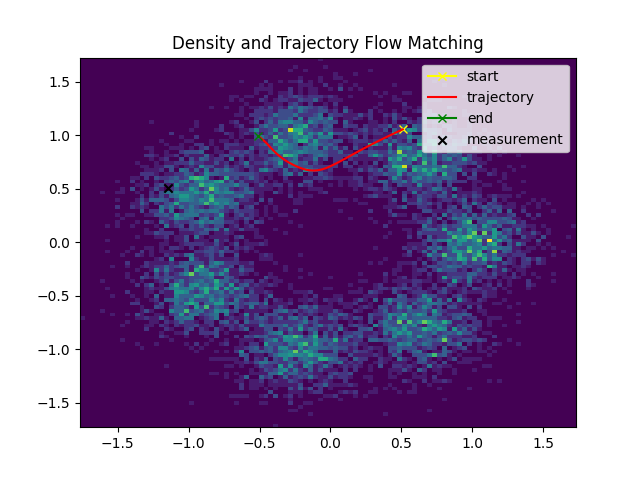

In [368]:
# plot trajecotry of one point
config = {'n_steps': 100, 'likelihood_weight': 0.004}
n_samples = 10000
bins = 75
x_t = torch.randn(1,2).to(device)
y = y_measurements[:1]
traj = guided_flow_sampler(denoiser_flow, y, config, x_t, save_traj=True)
plt.figure()
plt.title('Density and Trajectory')
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)
plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# plot meaasurement y
plt.scatter(y[0,0].detach().cpu().numpy(),y[0,1].detach().cpu().numpy(), color='black', marker='x')
# add legend
plt.legend(['start','trajectory','end', 'measurement'])
# name
plt.title(f'Density and Trajectory Flow Matching')


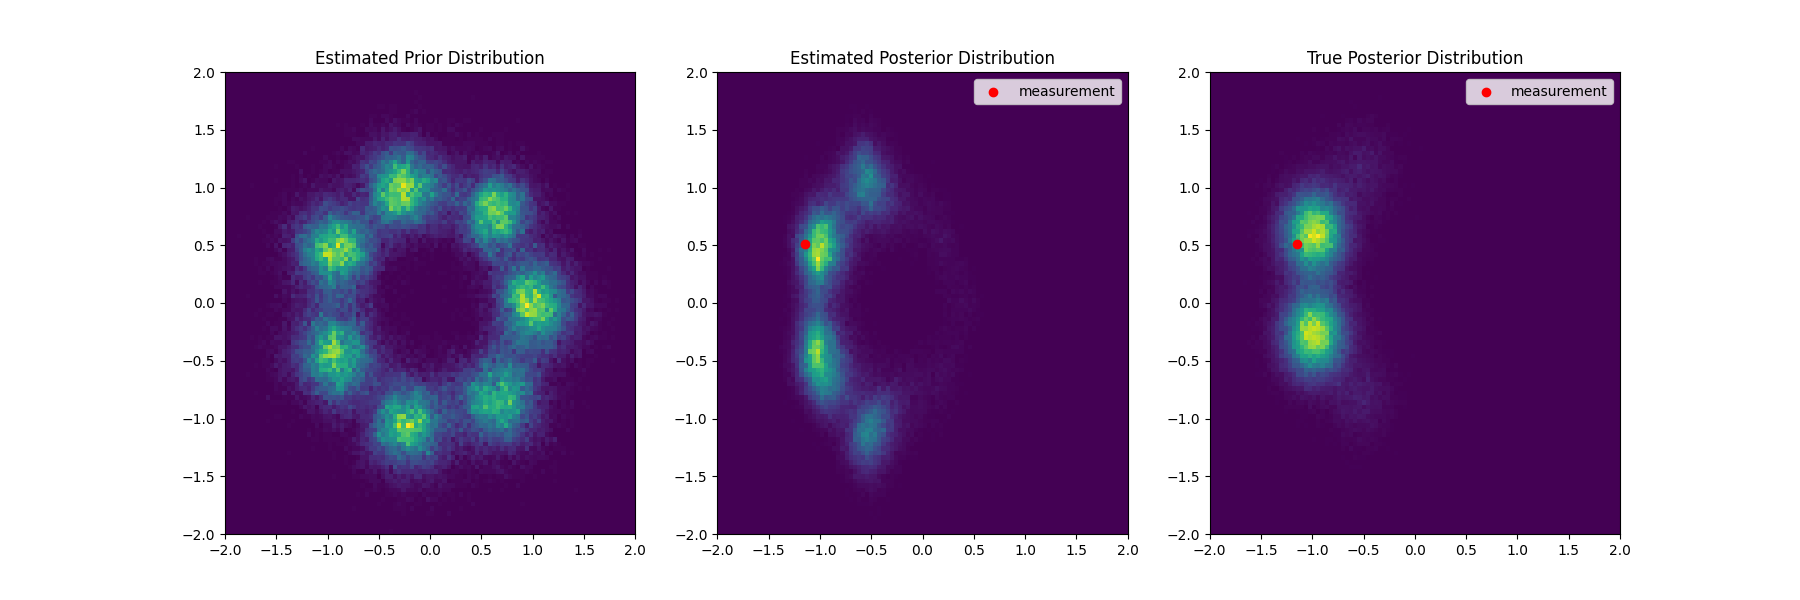

In [380]:
# compare posterior
config = {'n_steps': 100, 'likelihood_weight': 0.0045}
n_samples = 100000
bins = 100
x_t = torch.randn(n_samples,2).to(device)
y = y_measurements[:1]
x_0 = guided_flow_sampler(denoiser_flow, y, config, x_t)[-1]
config['likelihood_weight'] = 0.0
x_0_prior = guided_flow_sampler(denoiser_flow, y, config, x_t)[-1]
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].set_title('Estimated Prior Distribution')
axs[0].hist2d(x_0_prior[:,0], x_0_prior[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].set_title('Estimated Posterior Distribution')
hist = axs[1].hist2d(x_0[:,0], x_0[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])
axs[2].set_title('True Posterior Distribution')
hist = axs[2].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[2].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[2].legend(['measurement'])
plt.show()


In [493]:
# compute wassserstein distances between estimated prior and true prior
x_samples = gaussian_circle(100000)
# 1. DDPM
computed_wd = compute_WD(traj_xprior[-1], x_samples)
print(f"Computed Wasserstein Distance DDPM: {computed_wd}")
# 2. Flow Matching
computed_wd = compute_WD(x_0_prior, x_samples)
print(f"Computed Wasserstein Distance Flow Matching: {computed_wd}")

Computed Wasserstein Distance DDPM: 0.08779620618940512
Computed Wasserstein Distance Flow Matching: 0.047968193121503


In [14]:
# measure Wasserstein distance flow matching
wd_distances = []
for y in y_measurements:
    # compare posterior
    n_samples = 10000
    x_t = torch.randn(n_samples,2).to(device)
    x_0 = guided_flow_sampler(denoiser_flow, y, config, x_t)[-1]
    # sample from true posterior
    ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
    # histogram
    wasserstein_distance_histogram = compute_WD(ground_truth_samples, traj[-1])
    print("Wasserstein Distance on Binned Data:", wasserstein_distance_histogram)
    wd_distances.append(wasserstein_distance_histogram)
wd_distances = np.array(wd_distances)
print("Mean Wasserstein Distance:", np.mean(wd_distances))

Wasserstein Distance on Binned Data: 1.0926507253768438
Wasserstein Distance on Binned Data: 1.3108824277754902
Wasserstein Distance on Binned Data: 1.433022549307322
Wasserstein Distance on Binned Data: 1.9941229329234806
Wasserstein Distance on Binned Data: 1.2979221742161375
Wasserstein Distance on Binned Data: 1.851847948306655
Wasserstein Distance on Binned Data: 1.881800845347947
Wasserstein Distance on Binned Data: 2.0179317938219232
Wasserstein Distance on Binned Data: 1.5925324853895078
Wasserstein Distance on Binned Data: 2.181587856011329
Wasserstein Distance on Binned Data: 2.2197501463032365
Wasserstein Distance on Binned Data: 1.2886332378987952
Wasserstein Distance on Binned Data: 1.6950273253555799
Wasserstein Distance on Binned Data: 1.9069761018667362
Wasserstein Distance on Binned Data: 2.1297159935059526
Wasserstein Distance on Binned Data: 1.5437504765799477
Wasserstein Distance on Binned Data: 1.196709145892184
Wasserstein Distance on Binned Data: 1.46753989459191

KeyboardInterrupt: 

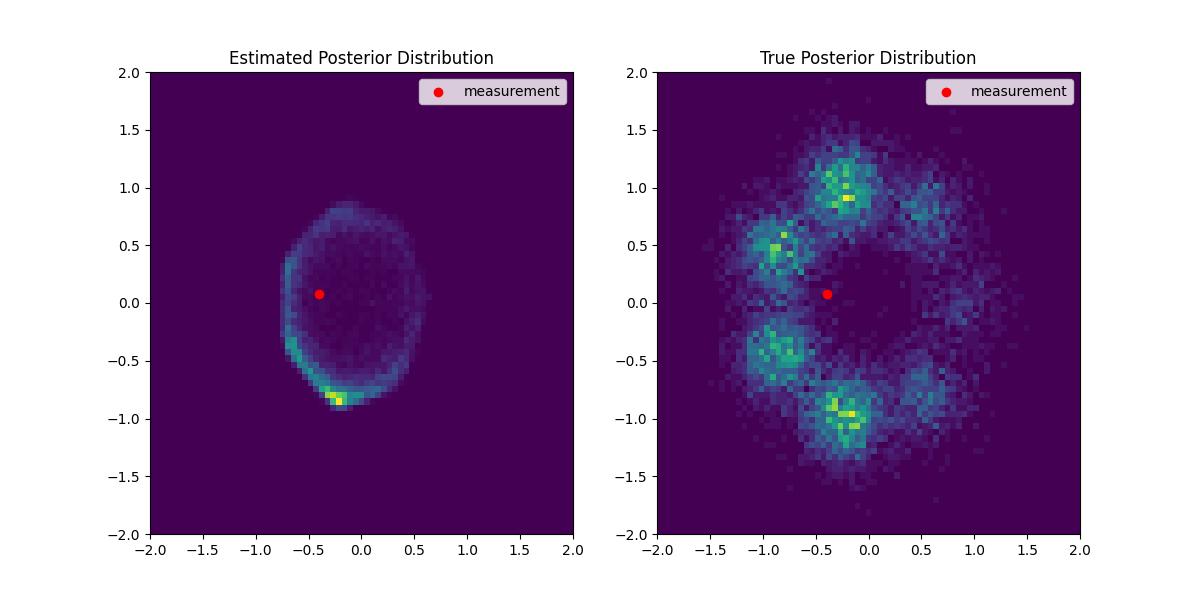

In [13]:
# variational inference DDIM T -> 0
n_samples = 10000
bins = 75
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.5, "likelihood_weight": 0.001, "regularizer_weight": 0.1}
x_t = torch.randn(n_samples,2).to(device)
y = y_measurements[:1]
x_mu = x_t
x_sigma = torch.ones_like(x_t)
save_traj = False
n_ddim_steps = ddim_config['n_ddim_steps']
n_steps = ddim_config['n_steps']
eta = ddim_config['eta']
regularizer_weight = ddim_config['regularizer_weight']
likelihood_weight = ddim_config['likelihood_weight']
skip = int(n_steps/n_ddim_steps)
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
if save_traj:
    traj = [x_t.detach().cpu().numpy()]
for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
    with torch.no_grad():
        eta_t = (1 + x_sigma**2* (alpha_cumprod[t]/(1-alpha_cumprod[t]))**2)**0.5
        a_t = alpha_cumprod[t]
        a_t_next = alpha_cumprod[t_next]
        eps = torch.randn(x_mu.shape[0],2).to(device)
        x_t = alpha_cumprod[t,None] * x_mu + eps * (1-alpha_cumprod[t,None])
        eps_pred = denoiser(torch.cat([x_t, torch.ones(x_t.shape[0],1).to(device)*t/1000], 1))
        # eps_pred = denoiser(x_t, torch.ones(x_t.shape[0]).to(device)*t)
        dmu_reg = (eps_pred) * (1-alpha_cumprod[t])/alpha_cumprod[t]
        # dsig_reg = 2 * 1/eta_t * (1-alpha_cumprod[t])/alpha_cumprod[t] * eps.T @ (eps_pred - eta_t * eps)**2 
        with torch.enable_grad():
            x_mu.requires_grad_()
            x_sigma.requires_grad_()
            y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_mu.T).T
            loss = torch.sum((y_generated - y)**2, dim=1)
            loss.backward(torch.ones_like(loss))
            gradients_mu = x_mu.grad
            gradients_sigma = x_sigma.grad
        # data term
        x_mu = x_mu - likelihood_weight *  gradients_mu - regularizer_weight * dmu_reg
        # x_sigma = x_sigma - regularizer_weight * dsig_reg - likelihood_weight * gradients_sigma
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
hist = axs[0].hist2d(x_mu[:,0], x_mu[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].legend(['measurement'])

# Plot true posterior distribution
axs[1].set_title('True Posterior Distribution')
hist = axs[1].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])


plt.show()
# compute Wasserstein distance of posterior samples and true posterior
estimated_samples = traj[-1]


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/jl/3dg2_4_119d9bmblgpt2b_gc0000gn/T/ipykernel_25920/742479296.py:65: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eps_pred = denoiser(torch.cat([x_t, (torch.ones(x_t.shape[0],1).to(device)*t[:,None]/1000).float()], 1))
100%|██████████| 1000/1000 [00:06<00:00, 158.51it/s]


mu: tensor([[ 0.6305,  0.1719],
        [-0.2216, -0.6949],
        [ 0.0476,  0.6599],
        ...,
        [ 0.2769,  0.4810],
        [-0.5894,  0.2383],
        [-0.1397,  0.7365]]) sigma: tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor(0.)


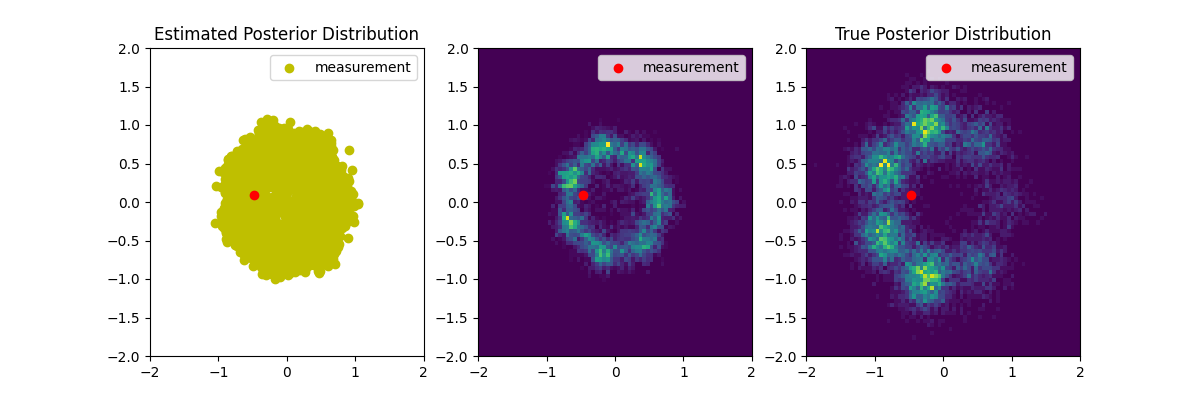

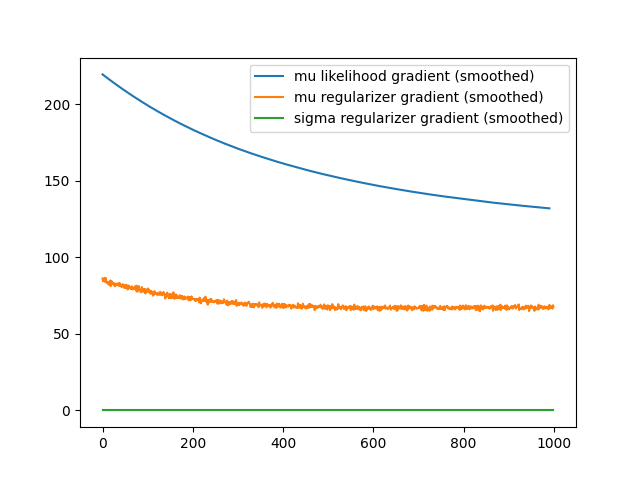

In [57]:
# variational inference DDIM: > random sampling , calculcated gradients
batch_size = 1
n_particles = 10000
n_samples = 10000
bins = 75
n_iterations= 1000
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0., "likelihood_weight": 0e-3, "regularizer_weight": 5e-3}
x_t = torch.randn(batch_size, n_particles,2).to(device)
y = y_measurements[:1]
x_mu = x_t[0]
x_t = x_t.reshape(-1,2)
x_sigma = torch.randn_like(x_mu).to(device)** 2 *0.
save_traj = False
n_ddim_steps = ddim_config['n_ddim_steps']
n_steps = ddim_config['n_steps']
eta = ddim_config['eta']
regularizer_weight = ddim_config['regularizer_weight']
likelihood_weight = ddim_config['likelihood_weight']
regularizer_weight_sig = 4e-3
likelihood_weight_sig = 4e-4
skip = int(n_steps/n_ddim_steps)
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
# use adam optimizer
optimizer = torch.optim.Adam([x_mu, x_sigma], lr=1e-3)
if save_traj:
    traj = [x_t.detach().cpu().numpy()]
x_mu_grad_likelihood = []
x_sigma_grad_likelihood = []
x_sigma_grad_regularizer = []
x_mu_grad_regularizer = []
for i in tqdm(range(n_iterations)):
    with torch.no_grad():
        start_idx = int(i * (n_steps-1) // n_iterations)
        start_idx = 0
        t_index = torch.randint(start_idx, n_steps-1, (batch_size*n_particles,))
        # t_index = (n_steps-1) * i // n_iterations
        # repeat 
        # t_index = torch.Tensor([t_index]).repeat(batch_size*n_particles).type(torch.int64).to(device)
        # if i < n_iterations//2:
        #     t_index = torch.randint(int((n_steps-1)*0.2), int((n_steps-1)* 0.98), (batch_size*n_particles,))
        # else:
        #     t_index = torch.randint(n_steps//2, int((n_steps-1)* 0.98), (batch_size*n_particles,))
        # t_index = torch.randint(0, n_steps-1, (batch_size*n_particles,))
        t = timesteps[t_index]
        t_next = timesteps[t_index+1]
        alpha_cumprod_t = alpha_cumprod[t][:,None]

        with torch.enable_grad():
            optimizer.zero_grad()
            x_mu.requires_grad_()
            x_sigma.requires_grad_()
            # sample x0
            eta_t = (1 + x_sigma.repeat(batch_size,1)**2* (alpha_cumprod[t, None]/(1-alpha_cumprod[t,None]))**2)**0.5
            y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_mu.T).T
            loss = (y_generated - y)**2
            loss.backward(torch.ones_like(loss))
            gradients_mu = x_mu.grad
            # repeat x0 along batch dimension batch_size times
            eps = torch.randn(batch_size*n_particles,2).to(device)
            x_t = alpha_cumprod_t * x_mu.repeat(batch_size,1) + eps * eta_t*(1-alpha_cumprod_t)
            
            eps_pred = denoiser(torch.cat([x_t, (torch.ones(x_t.shape[0],1).to(device)*t[:,None]/1000).float()], 1))
            dmu_reg = (eps_pred - 1/eta_t*eps) #* (1-alpha_cumprod_t)/alpha_cumprod_t
            dmu_reg = dmu_reg.reshape(batch_size, n_particles, 2)
            dmu_reg = dmu_reg.mean(dim=0)
            # compute diagonal bxd of jacobian matrix bxdxd
            jacobian_diagonal = x_sigma.repeat(batch_size,1) * 1/eta_t * (alpha_cumprod_t**2)/(1-alpha_cumprod_t) * eps
            dsig_reg = jacobian_diagonal * (eps_pred - 1/eta_t * eps) #* (1-alpha_cumprod_t)/alpha_cumprod_t
            dsig_reg = dsig_reg.reshape(batch_size, n_particles, 2)
            dsig_reg = dsig_reg.mean(dim=0)
            
            # data term sigma_reg + mu_reg + dataterm
            # total_loss = regularizer_weight * (dsig_reg.detach() * x_sigma + dmu_reg.detach() * x_mu) + loss * likelihood_weight
            # total_loss.backward(torch.ones_like(total_loss))
            x_mu_grad_likelihood.append(torch.norm(x_mu.grad).item())
            # x_sigma_grad_likelihood.append(torch.norm(x_sigma.grad).item())
            x_mu_grad_regularizer.append(torch.norm(dmu_reg).item())
            x_sigma_grad_regularizer.append(torch.norm(dsig_reg).item())
        x_mu = x_mu - likelihood_weight *  gradients_mu - regularizer_weight * dmu_reg
        x_sigma = x_sigma - regularizer_weight_sig * dsig_reg 
            # optimizer.step()
        
        # log gradient norms
        
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
print(f"mu: {x_mu} sigma: {x_sigma}")
print(x_sigma.min())
# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
# generate samples from estimated posterior
particle_idx = torch.randint(0, n_particles, (n_samples,))
x_samples = x_mu[particle_idx] + torch.randn(n_samples,2) * x_sigma[particle_idx]
x_samples = x_samples.detach().cpu().numpy()
axs[0].scatter(x_mu[:,0].detach().cpu().numpy(), x_mu[:,1].detach().cpu().numpy(), c='y')
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].set_xlim([-2, 2])
axs[0].set_ylim([-2, 2])
axs[0].legend(['measurement'])

hist = axs[1].hist2d(x_samples[:,0], x_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])

# Plot true posterior distribution
axs[2].set_title('True Posterior Distribution')
hist = axs[2].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[2].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[2].legend(['measurement'])
# get most frequent value of posterior
plt.show()

plt.figure()
x_mu_grad_likelihood = np.convolve(x_mu_grad_likelihood, np.ones(10)/10, mode='valid')
plt.plot(x_mu_grad_likelihood, label='mu likelihood gradient (smoothed)')
plt.plot(x_mu_grad_regularizer, label='mu regularizer gradient (smoothed)')
plt.plot(x_sigma_grad_regularizer, label='sigma regularizer gradient (smoothed)')
plt.legend()
plt.show()


In [309]:
class GaussianMixtureModel(torch.nn.Module):
    """
    A class for Gaussian Mixture Models (GMM) with methods to compute the probability density
    and the gradient of the log-density.
    """
    def __init__(self, n_gaussians, dim):
        """
        Initialize the GMM with weights, means, and covariances.
        Args:
            n_gaussians (int): The number of Gaussians in the mixture.
            dim (int): The dimensionality of the data.
        """
        super(GaussianMixtureModel, self).__init__()
        self.weights = torch.rand(n_gaussians)
        # nomralize weights
        self.weights = self.weights / torch.sum(self.weights)
        self.weights = nn.Parameter(self.weights)
        self.means = nn.Parameter(torch.randn(n_gaussians, dim))
        self.dim = dim  # Dimensionality of the data
        # Number of parameters needed for a lower triangular matrix
        self.num_params = self.dim * (self.dim + 1) // 2
        # Trainable parameters for the lower triangular matrix
        self.L = nn.Parameter(torch.randn(n_gaussians, self.num_params))
        self.K = n_gaussians  # Number of components
        self.relu = nn.ReLU()
        
    def get_covariances(self):
        """
        Compute the covariance matrices from the lower triangular matrix.
        Returns:
            torch.Tensor: Covariance matrices (K x d x d tensor).
        """
        L = torch.zeros(self.K, self.dim, self.dim)
        L_idx = torch.tril_indices(self.dim, self.dim)
        L[:, L_idx[0], L_idx[1]] = self.L
        # Ensure diagonal elements are positive
        diag_idx = torch.arange(self.dim)
        L[:, diag_idx, diag_idx] = torch.exp(L[:, diag_idx, diag_idx])  # Exponentiate diagonal for positivity
        covariances = L @ L.permute(0, 2, 1)  # Multiply by its transpose to get the covariance matrix
        return covariances

    def multivariate_gaussian(self, x, mean, cov):
        """
        Compute the probability density of a multivariate Gaussian.
        Args:
            x (torch.Tensor): The data point (d-dimensional vector) with batch dimension.
            mean (torch.Tensor): The mean of the Gaussian (d-dimensional vector).
            cov (torch.Tensor): The covariance matrix of the Gaussian (d x d matrix).
        Returns:
            torch.Tensor: The probability density of the Gaussian at x.
        """
        log_prob = torch.distributions.MultivariateNormal(mean, cov).log_prob(x)
        return torch.exp(log_prob)

    def pdf(self, x):
        """
        Compute the probability density of the GMM at a given point.
        Args:
            x (torch.Tensor): The data point (d-dimensional vector) with batch dimension.
        Returns:
            float: The probability density of the GMM at x.
        """
        covariances = self.get_covariances()
        return torch.sum(torch.stack([
            self.relu(self.weights[k]) * self.multivariate_gaussian(x, self.means[k], covariances[k])
            for k in range(self.K)
        ]), dim=0)

    def log_pdf_gradient(self, x, cov_noise):
        """
        Compute the gradient of the log of the GMM w.r.t. x.
        Args:
            x (torch.Tensor): The data point (d-dimensional vector) with batch dimension.
            cov_noise (torch.Tensor): vector of noise covariances with shape batch
        Returns:
            torch.Tensor: The gradient of the log of the GMM w.r.t. x (d-dimensional vector) with batch dimension.
        """
        # Compute the responsibilities
        covariances = self.get_covariances()
        # covariance of the noise
        cov_noise = torch.eye(self.dim, self.dim)[None,...] * cov_noise[...,None]

        densities = torch.stack([
            self.relu(self.weights[k]) * self.multivariate_gaussian(x, self.means[k].repeat(x.shape[0],1), covariances[k][None]+cov_noise)
            for k in range(self.K)
        ], dim=0)
        total_density = torch.sum(densities, dim=0)
        responsibilities = densities / total_density
        # Compute the gradient
        gradient = torch.zeros_like(x)
        for k in range(self.K):
            cov_inv = torch.inverse(covariances[k])
            diff = x - self.means[k]
            gradient -= responsibilities[k].unsqueeze(-1) * (cov_inv @ diff.T).T

        return gradient
    
    def sample(self, n_samples):
        """
        Sample from the GMM.
        Args:
            n_samples (int): The number of samples to generate.
        Returns:
            torch.Tensor: The generated samples.
        """
        covariances = self.get_covariances()
        # Sample index
        k = torch.multinomial(self.relu(self.weights), n_samples, replacement=True)
        # Sample from the corresponding Gaussian
        samples = self.means[k] + torch.einsum('bij, bj -> bi', torch.cholesky(covariances[k]), torch.randn(n_samples, self.dim))
        return samples
        

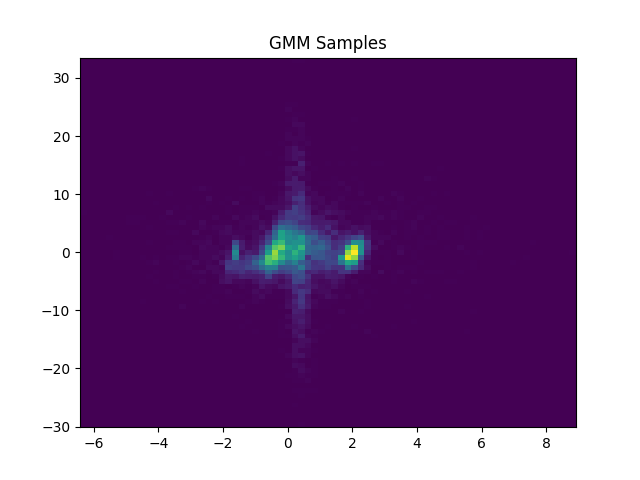

In [310]:
# test gmm model
gmm = GaussianMixtureModel(10, 2)
# manually set means and covariances for 2d example
# gmm.means = nn.Parameter(torch.tensor([[0., 0.], [1., 1.], [-1., -1.]]))
# print(torch.tril(torch.linalg.cholesky(torch.tensor([[[1., 0.], [0.5, 0.5]], [[0.5, 0.5], [0.5, 1.]], [[1., 0.], [0., 1.]]]))).shape)
# gmm.L = nn.Parameter(torch.tril(torch.linalg.cholesky(torch.tensor([[[1., 0.], [0.5, 0.5]], [[0.5, 0.5], [0.5, 1.]], [[1., 0.], [0., 1.]]]))))
# gmm.weights = nn.Parameter(torch.tensor([0.3, 0.5, 0.2]))
samples = gmm.sample(10000).detach().cpu().numpy()
# plot histogram
plt.figure()
plt.hist2d(samples[:,0], samples[:,1], bins=75)
plt.title('GMM Samples')
plt.show()


100%|██████████| 1000/1000 [00:06<00:00, 166.12it/s]


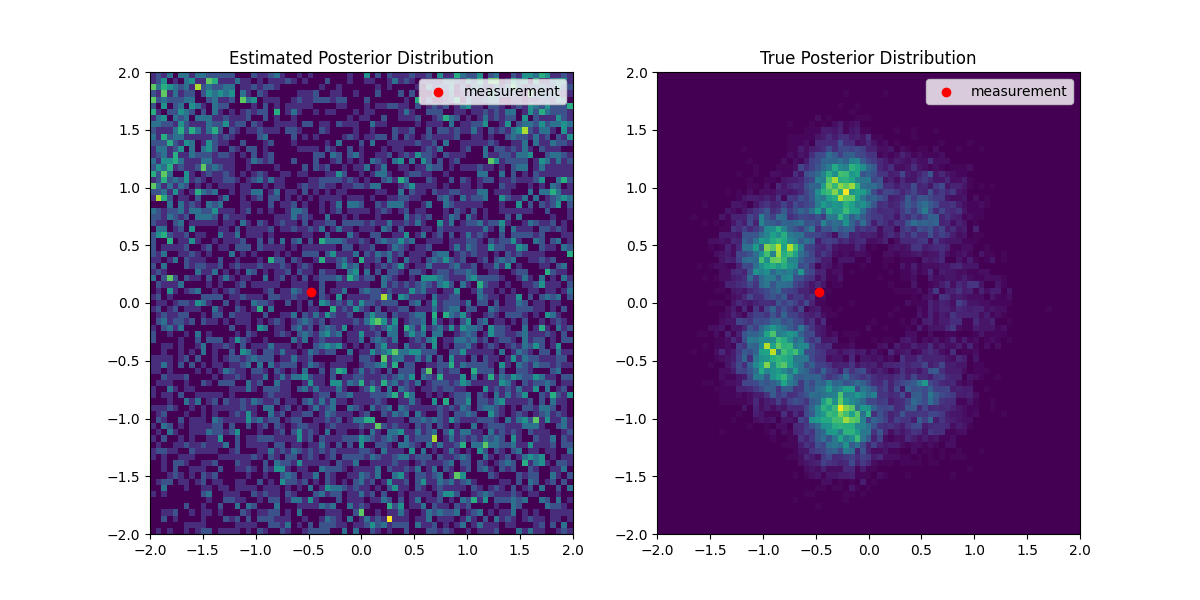

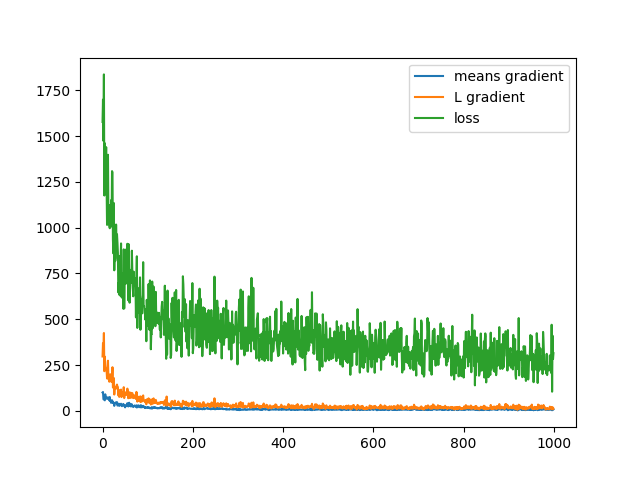

In [312]:
# GMM as posterior
n_gaussians = 16
batch_size = 64
gmm = GaussianMixtureModel(n_gaussians, 2).to(device)
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 1., "likelihood_weight": 0.0, "regularizer_weight": 0.9}
optimizer = torch.optim.Adam(gmm.parameters(), lr=1e-3)
# create DDPM scheduler
betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
n_iterations = 1000
n_steps = ddim_config['n_steps']
skip = int(n_steps/n_ddim_steps)
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
timesteps = torch.tensor(timesteps).to(device)
# log gradients
means_grad = []
L_grad = []
loss_list = []
for i in tqdm(range(n_iterations)):
    with torch.no_grad():
        start_idx = 0
        t_index = torch.randint(0, n_steps-1, (batch_size,))
        t = timesteps[t_index]
        alpha_cumprod_t = alpha_cumprod[t][:,None]
        if alpha_cumprod_t.ndim == 1:
            alpha_cumprod_t = alpha_cumprod_t[None]
            t = t[None]

        with torch.enable_grad():
            optimizer.zero_grad()

            # compute data term
            y_generated = (torch.Tensor(measurement_model.A).to(device) @ gmm.means.T).T
            dataterm = torch.sum((y_generated - y)**2)

            # compute regularizer term
            eps = torch.randn(batch_size,2).to(device)
            x_0_samples = gmm.sample(batch_size)
            # add noise
            x_t = alpha_cumprod_t * x_0_samples + eps * (1-alpha_cumprod_t)
            # compute scores
            t = torch.Tensor(t).to(device)
            eps_pred = denoiser(torch.cat([x_t, t[:, None] / 1000], 1))
            # compute regularizer term
            # get grad of log likelihood
            grad_log_likelihood = gmm.log_pdf_gradient(x_t, (1-alpha_cumprod_t))
            reg_term = torch.sum((eps_pred - grad_log_likelihood)**2)
            total_loss = dataterm * ddim_config['likelihood_weight'] + reg_term * ddim_config['regularizer_weight']
            loss_list.append(total_loss.item())
            total_loss.backward()
            # check gradients
            means_grad.append(torch.norm(gmm.means.grad, dim=1).mean().item())
            L_grad.append(torch.norm(gmm.L.grad, dim=1).mean().item())
            optimizer.step()
            

# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
# generate samples from estimated posterior
samples = gmm.sample(n_samples)
axs[0].hist2d(samples[:,0].detach().cpu().numpy(), samples[:,1].detach().cpu().numpy(), bins=bins, range=[[-2, 2], [-2, 2]])
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].legend(['measurement'])

axs[1].set_title('True Posterior Distribution')
hist = axs[1].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])
plt.show()

plt.figure()
plt.plot(means_grad, label='means gradient')
plt.plot(L_grad, label='L gradient')
plt.plot(loss_list, label='loss')
plt.legend()
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/jl/3dg2_4_119d9bmblgpt2b_gc0000gn/T/ipykernel_25920/2648868229.py:70: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eps_pred = denoiser(torch.cat([x_t, (torch.ones(x_t.shape[0],1).to(device)*t[:,None]/1000).float()], 1))
100%|██████████| 1000/1000 [00:00<00:00, 2315.28it/s]


tensor(0.1097, grad_fn=<MinBackward1>)
mu: tensor([[ 0.5550, -0.6385]], requires_grad=True) sigma: tensor([[0.5748, 0.1097]], grad_fn=<SoftplusBackward0>)


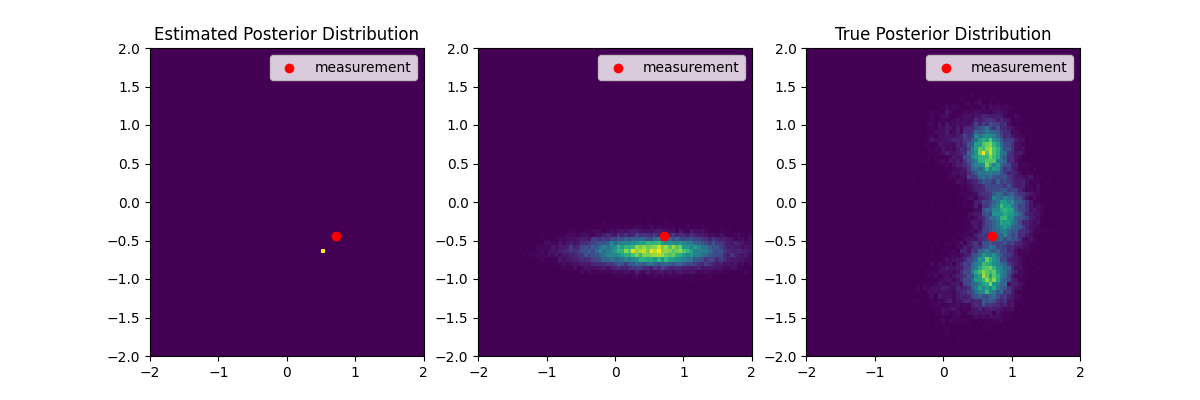

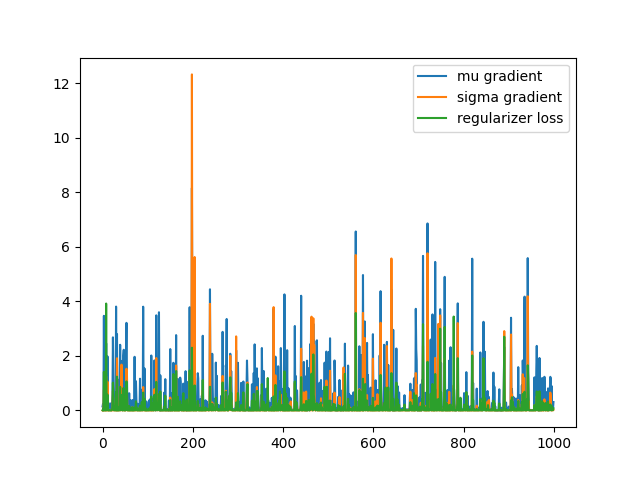

In [486]:
# variational inference DDIM: > random sampling, propagated gradients
batch_size = 1
n_particles = 1
n_samples = 20000
bins = 75
n_iterations= 1000
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0., "likelihood_weight": 0.05, "regularizer_weight": 0.9}
x_t = torch.randn(batch_size, n_particles,2).to(device)
y = y_measurements[1:2]
x_mu = x_t[0]
x_t = x_t.reshape(-1,2)
x_rawsigma = torch.randn_like(x_mu).to(device) 
save_traj = False
n_ddim_steps = ddim_config['n_ddim_steps']
n_steps = ddim_config['n_steps']
eta = ddim_config['eta']
regularizer_weight = ddim_config['regularizer_weight']
likelihood_weight = ddim_config['likelihood_weight']
regularizer_weight_sig = 4e-3
likelihood_weight_sig = 4e-4
skip = int(n_steps/n_ddim_steps)
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
# use adam optimizer
softplus = torch.nn.Softplus(beta=2)

optimizer = torch.optim.Adam([{'params': x_mu, 'lr': 1e-1}, {'params': x_rawsigma, 'lr': 5e-4}], lr=1e-1, betas=(0.5, 0.9))
if save_traj:
    traj = [x_t.detach().cpu().numpy()]
x_mu_grad = []
x_sigma_grad = []
loss_list = []
for i in tqdm(range(n_iterations)):
    with torch.no_grad():
        start_idx = int(i * (n_steps-1) // n_iterations)
        start_idx = 0
        t_index = torch.randint(start_idx, n_steps-1, (batch_size*n_particles,))
        # t_index =  n_steps - (n_steps-1) * i // n_iterations - 1
        # # repeat 
        # t_index = torch.Tensor((t_index,)).repeat(batch_size*n_particles).type(torch.int64).to(device)
        # if i < n_iterations//2:
        #     t_index = torch.randint(int((n_steps-1)*0.02), int((n_steps-1)* 0.98), (batch_size*n_particles,))
        # else:
        #     t_index = torch.randint(0, n_steps//2, (batch_size*n_particles,))
        # t_index = torch.randint(0, n_steps-1, (batch_size*n_particles,))
        t = timesteps[t_index]
        # t_next = timesteps[t_index+1]
        alpha_cumprod_t = alpha_cumprod[t,None]
        if alpha_cumprod_t.ndim == 1:
            alpha_cumprod_t = alpha_cumprod_t[None]
            t = t[None]

        with torch.enable_grad():
            optimizer.zero_grad()
            x_mu.requires_grad_()
            x_rawsigma.requires_grad_()
            # sample x0
            eta_t = (1 + softplus(x_rawsigma).repeat(batch_size,1)**2* (alpha_cumprod[t, None]/(1-alpha_cumprod[t,None]))**2)**0.5
            y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_mu.T).T
            loss = (y_generated - y)**2
            # loss.backward(torch.ones_like(loss))
            # gradients_mu = x_mu.grad
            # gradients_sigma = x_sigma.grad
            # repeat x0 along batch dimension batch_size times
            eps = torch.randn(batch_size*n_particles,2).to(device)
            x_t = alpha_cumprod_t * x_mu.repeat(batch_size,1) + eps * eta_t*(1-alpha_cumprod_t)
            
            eps_pred = denoiser(torch.cat([x_t, (torch.ones(x_t.shape[0],1).to(device)*t[:,None]/1000).float()], 1))
            
            # data term sigma_reg + mu_reg + dataterm
            reg_loss = regularizer_weight * (eps_pred - eps)**2 #* (1-alpha_cumprod_t) / alpha_cumprod_t
            reg_loss = reg_loss.reshape(batch_size, n_particles, 2).mean(dim=0)
            total_loss = reg_loss + loss * likelihood_weight #+ x_sigma.sum() * 1e-2
            total_loss.backward(torch.ones_like(total_loss))
            x_mu_grad.append(torch.norm(x_mu.grad, dim=1).mean().item())
            x_sigma_grad.append(torch.norm(x_rawsigma.grad, dim=1).mean().item())
            loss_list.append(reg_loss.mean().item())
            # x_mu_grad_regularizer.append(torch.norm(dmu_reg).item())
            # x_sigma_grad_regularizer.append(torch.norm(dsig_reg).item())
        # x_mu = x_mu - likelihood_weight *  gradients_mu - regularizer_weight * dmu_reg
        # x_sigma = x_sigma - regularizer_weight_sig * dsig_reg - likelihood_weight_sig * gradients_sigma
            optimizer.step()
            # ensure x_sigma is positive
        
        # log gradient norms
print(softplus(x_rawsigma).min())
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
print(f"mu: {x_mu} sigma: {softplus(x_rawsigma)}")
# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
# generate samples from estimated posterior
# sa,ple from estimated posterior
particle_idx = torch.randint(0, n_particles, (n_samples,))
x_samples = x_mu[particle_idx] + torch.randn(n_samples,2) * softplus(x_rawsigma)[particle_idx]

x_samples = x_samples.detach().cpu().numpy()
axs[0].hist2d(x_mu[:,0].detach().cpu().numpy(), x_mu[:,1].detach().cpu().numpy(), range=[[-2, 2], [-2, 2]], bins=bins)
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].set_xlim([-2, 2])
axs[0].set_ylim([-2, 2])
axs[0].legend(['measurement'])

hist = axs[1].hist2d(x_samples[:,0], x_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])

# Plot true posterior distribution
axs[2].set_title('True Posterior Distribution')
hist = axs[2].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[2].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[2].legend(['measurement'])
# get most frequent value of posterior
plt.show()

plt.figure()
# x_mu_grad_likelihood = np.convolve(x_mu_grad_likelihood, np.ones(10)/10, mode='valid')
# x_sigma_grad_likelihood = np.convolve(x_sigma_grad_likelihood, np.ones(10)/10, mode='valid')
plt.plot(x_mu_grad, label='mu gradient')
plt.plot(x_sigma_grad, label='sigma gradient')
plt.plot(loss_list, label='regularizer loss')
# plt.plot(x_sigma_grad_regularizer, label='sigma regularizer gradient (smoothed)')
plt.legend()
plt.show()



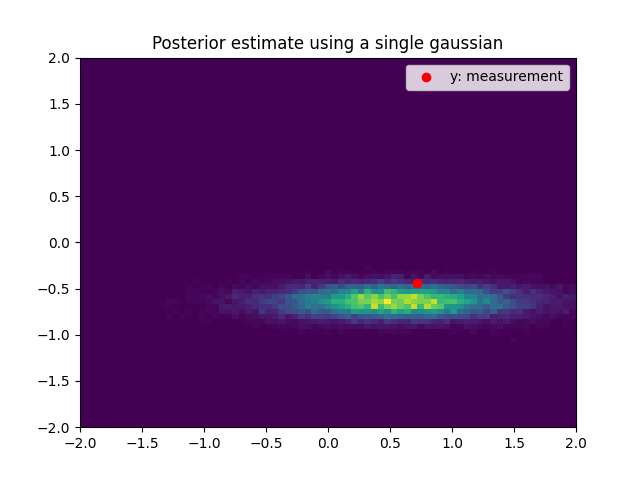

In [487]:
particle_idx = 0
x_samples = x_mu[particle_idx] + torch.randn(n_samples,2) * softplus(x_rawsigma)[particle_idx]
x_samples = x_samples.detach().cpu().numpy()
plt.figure()
# set title
plt.title('Posterior estimate using a single gaussian')
plt.hist2d(x_samples[:,0], x_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
plt.scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r', label='y: measurement')
plt.legend()
plt.show()